<a href="https://colab.research.google.com/github/DeepaliSaini4/6D-Pose-GRPoseNet/blob/main/6D_Pose_GRPoseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install core dependencies
!pip -qq install torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip -qq install git+https://github.com/facebookresearch/segment-anything.git
!pip -qq install gdown fastsam


  Preparing metadata (setup.py) ... done


In [2]:
# make folders
!mkdir -p /content/grposenet_phase2/assets /content/grposenet_phase2/outputs

# download SAM ViT-B weights (smallest)
!wget -q -O /content/grposenet_phase2/assets/sam_vit_b.pth \
  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

SAM_CKPT = "/content/grposenet_phase2/assets/sam_vit_b.pth"
PROJECT_DIR = "/content/grposenet_phase2"
print("Assets ready at:", SAM_CKPT)


Assets ready at: /content/grposenet_phase2/assets/sam_vit_b.pth


In [3]:
# -------------------------------------------------------------
# Load Core Models (SAM + DINOv2)
# -------------------------------------------------------------
# SAM     : Zero-shot segmentation model for detecting objects
# DINOv2  : Feature extractor for semantic + geometric matching
# -------------------------------------------------------------

import os, math, numpy as np
from PIL import Image
import torch
import torchvision.transforms as T
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Select device (GPU preferred)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Load Segment Anything (SAM) ---
sam = sam_model_registry["vit_b"](
    checkpoint="/content/grposenet_phase2/assets/sam_vit_b.pth"
).to(device)
mask_generator = SamAutomaticMaskGenerator(sam)
print("SAM model loaded on:", device)

# --- Load DINOv2 (Visual Feature Extractor) ---
# This will auto-download weights the first time
dino = torch.hub.load(
    'facebookresearch/dinov2', 'dinov2_vits14', source='github'
).to(device).eval()
print("DINOv2 model loaded on:", device)

# --- Define image transform pipeline for DINOv2 ---
dino_tf = T.Compose([
    T.Resize(256),         # resize shorter side to 256
    T.CenterCrop(224),     # crop to 224x224 (DINOv2 input)
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])


SAM model loaded on: cuda
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth


100%|██████████| 84.2M/84.2M [00:00<00:00, 392MB/s]


DINOv2 model loaded on: cuda


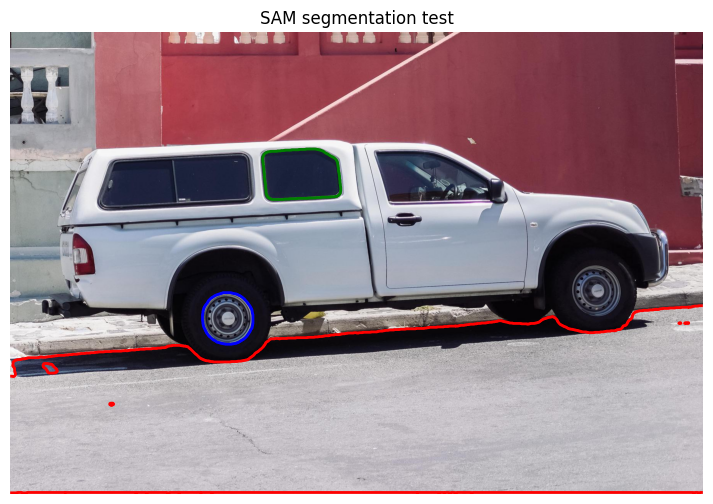

Total masks detected: 47


In [4]:
# -------------------------------------------------------------
# Test SAM on a sample image
# -------------------------------------------------------------

import requests
from io import BytesIO
import matplotlib.pyplot as plt

# sample image for testing segmentation
url = "https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg"
image = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

# generate segmentation masks
masks = mask_generator.generate(np.array(image))

# visualize the top 3 masks detected
plt.figure(figsize=(12, 6))
plt.imshow(image)
for i, m in enumerate(masks[:3]):
    plt.contour(m["segmentation"], colors=[["red","green","blue"][i % 3]], linewidths=2)
plt.title("SAM segmentation test")
plt.axis("off")
plt.show()

print(f"Total masks detected: {len(masks)}")


In [5]:
# -------------------------------------------------------------
#Test DINOv2 feature extraction
# -------------------------------------------------------------

# pick one object mask (for example, the largest one)
largest_mask = max(masks, key=lambda m: m["area"])
bbox = largest_mask["bbox"]  # [x, y, w, h]

# crop the image to that mask area
x, y, w, h = map(int, bbox)
obj_crop = image.crop((x, y, x+w, y+h))

# convert to tensor and extract feature
img_tensor = dino_tf(obj_crop).unsqueeze(0).to(device)
with torch.no_grad():
    feature = dino(img_tensor)

print("Feature tensor shape:", feature.shape)


Feature tensor shape: torch.Size([1, 384])


In [6]:
# -------------------------------------------------------------
#  Minimal OpenWorldDetector (segment -> crop -> feature)
# -------------------------------------------------------------
# Uses globally loaded: mask_generator (SAM), dino (DINOv2), dino_tf
# Provides:
#   - segment(image_pil) -> list of SAM masks
#   - crop_by_mask(image_pil, mask_dict) -> PIL crop of the object
#   - featurize(crop_pil) -> np.array feature (L2-normalized)
#   - match(target_crop, reference_crops) -> cosine-sim scores
# -------------------------------------------------------------

import numpy as np
import torch.nn.functional as F

class OpenWorldDetector:
    def __init__(self, mask_generator, dino_model, dino_transform, device='cuda'):
        self.mask_generator = mask_generator
        self.dino = dino_model
        self.tf = dino_transform
        self.device = device

    def segment(self, image_pil):
        # returns list of SAM mask dicts
        return self.mask_generator.generate(np.array(image_pil))

    def crop_by_mask(self, image_pil, mask_dict):
        # crops the image to the mask's bbox and zeroes background
        x, y, w, h = map(int, mask_dict["bbox"])
        full = np.array(image_pil)
        seg = mask_dict["segmentation"].astype(bool)
        obj = full.copy()
        obj[~seg] = 0
        obj = obj[y:y+h, x:x+w]
        return Image.fromarray(obj)

    def featurize(self, crop_pil):
        # returns global DINO feature (L2-normalized)
        with torch.no_grad():
            t = self.tf(crop_pil).unsqueeze(0).to(self.device)
            f = self.dino(t)             # [1, 384] for ViT-S/14
            f = F.normalize(f, dim=1)    # L2 normalize
        return f.squeeze(0).cpu().numpy()

    def match(self, target_crop, reference_crops):
        # cosine similarities between target feature and each reference feature
        tf = self.featurize(target_crop)
        rfs = np.stack([self.featurize(rc) for rc in reference_crops])  # [N, dim]
        sims = tf @ rfs.T  # dot-product since features are L2-normalized
        return sims  # shape [N]

detector = OpenWorldDetector(mask_generator, dino, dino_tf, device)
print("OpenWorldDetector ready.")


OpenWorldDetector ready.


Reference scores: [0.0527 0.0735 0.0412 0.2299 0.3246]
Best reference index: 4 score: 0.3246
Saved: /content/grposenet_phase2/outputs/match_grid.png


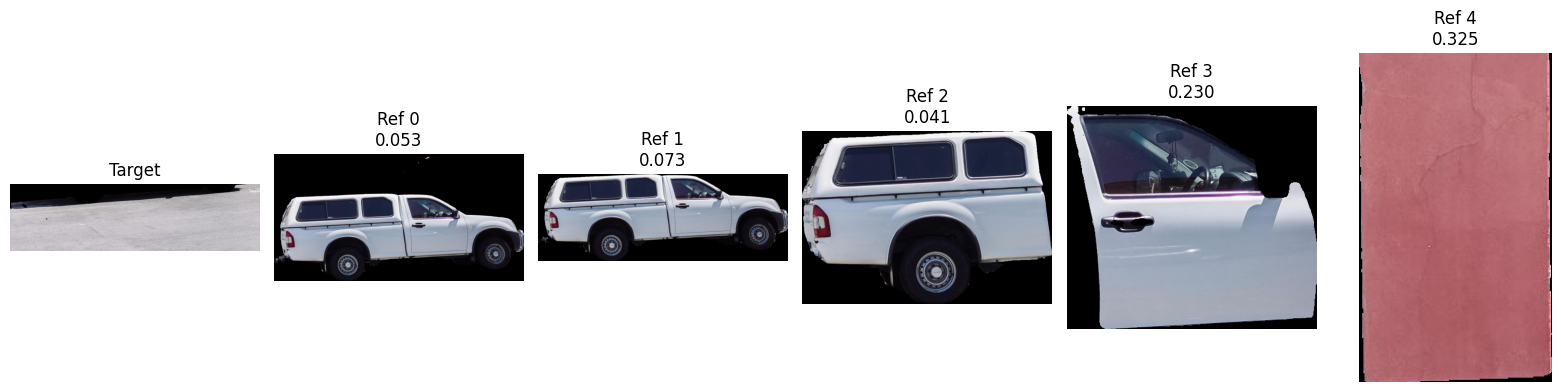

In [7]:
# -------------------------------------------------------------
# Build a tiny reference set and test matching
# -------------------------------------------------------------

import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

# sort masks by area (descending)
m_sorted = sorted(masks, key=lambda m: m["area"], reverse=True)
target_m = m_sorted[0]          # largest mask -> act as target
ref_ms    = m_sorted[1:6]       # next 5 masks -> act as reference set

# crops
target_crop = detector.crop_by_mask(image, target_m)
ref_crops   = [detector.crop_by_mask(image, m) for m in ref_ms]

# compute cosine-similarity scores
sims = detector.match(target_crop, ref_crops)  # shape [5]
best_idx = int(np.argmax(sims))
best_score = float(sims[best_idx])

print("Reference scores:", np.round(sims, 4))
print("Best reference index:", best_idx, "score:", round(best_score, 4))

# visualize target + refs grid with scores
fig, axs = plt.subplots(1, 6, figsize=(16, 4))
axs[0].imshow(target_crop); axs[0].set_title("Target"); axs[0].axis("off")
for i, rc in enumerate(ref_crops):
    axs[i+1].imshow(rc); axs[i+1].set_title(f"Ref {i}\n{float(sims[i]):.3f}")
    axs[i+1].axis("off")
plt.tight_layout()

# save for report
out_path = "/content/grposenet_phase2/outputs/match_grid.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
print("Saved:", out_path)


In [8]:
# -------------------------------------------------------------
# Save current implementation as detector_module.py
# -------------------------------------------------------------

module_path = "/content/grposenet_phase2/detector_module.py"

code = r'''
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

class OpenWorldDetector:
    def __init__(self, mask_generator, dino_model, dino_transform, device='cuda'):
        self.mask_generator = mask_generator
        self.dino = dino_model
        self.tf = dino_transform
        self.device = device

    def segment(self, image_pil):
        return self.mask_generator.generate(np.array(image_pil))

    def crop_by_mask(self, image_pil, mask_dict):
        x, y, w, h = map(int, mask_dict["bbox"])
        full = np.array(image_pil)
        seg = mask_dict["segmentation"].astype(bool)
        obj = full.copy()
        obj[~seg] = 0
        obj = obj[y:y+h, x:x+w]
        return Image.fromarray(obj)

    def featurize(self, crop_pil):
        with torch.no_grad():
            t = self.tf(crop_pil).unsqueeze(0).to(self.device)
            f = self.dino(t)
            f = F.normalize(f, dim=1)
        return f.squeeze(0).cpu().numpy()

    def match(self, target_crop, reference_crops):
        tf = self.featurize(target_crop)
        rfs = np.stack([self.featurize(rc) for rc in reference_crops])
        sims = tf @ rfs.T
        return sims
'''

with open(module_path, "w") as f:
    f.write(code)

print("Saved module:", module_path)


Saved module: /content/grposenet_phase2/detector_module.py


In [9]:
# create minimal repo skeleton
!mkdir -p /content/grposenet_phase2/notebooks /content/grposenet_phase2/outputs
!cp "/content/GRPoseNet_Phase2.ipynb" /content/grposenet_phase2/notebooks/ 2>/dev/null || true

# README (concise, class-ready)
readme = """# GRPoseNet-Phase2

Minimal implementation of the detector stage for GRPoseNet (SAM + DINOv2) with a Colab notebook.
- Open-world segmentation (SAM)
- DINOv2 features
- Mask-based cropping and cosine matching
- Demo outputs in `outputs/`

## How to run (Colab)
1) Enable GPU
2) Install deps (see Step 2)
3) Run Steps 4–8 to reproduce segmentation + matching
4) Outputs saved in `outputs/`

## Structure
- `notebooks/GRPoseNet_Phase2.ipynb` — runnable notebook
- `detector_module.py` — clean class for detector
- `outputs/` — saved figures
- `assets/` — model weights (SAM)

## Notes
This repo currently includes the detector demo. Selector + refiner can be added similarly in modules.
"""

with open("/content/grposenet_phase2/README.md", "w") as f:
    f.write(readme)

# .gitignore (keeps repo clean)
gitignore = """# outputs and caches
outputs/
__pycache__/
*.pth
*.pt
*.ckpt
*.ipynb_checkpoints/
"""
with open("/content/grposenet_phase2/.gitignore", "w") as f:
    f.write(gitignore)

print("Repo files prepared at /content/grposenet_phase2")
!ls -R /content/grposenet_phase2


Repo files prepared at /content/grposenet_phase2
/content/grposenet_phase2:
assets	detector_module.py  notebooks  outputs	README.md

/content/grposenet_phase2/assets:
sam_vit_b.pth

/content/grposenet_phase2/notebooks:

/content/grposenet_phase2/outputs:
match_grid.png


In [15]:
%cd /content/grposenet_phase2

# fetch and merge remote 'main' into your local main
!git fetch origin main
!git pull origin main --allow-unrelated-histories

# if the pull succeeded with no conflicts, push:
!git push -u origin main


/content/grposenet_phase2
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1.50 KiB | 1.50 MiB/s, done.
From https://github.com/DeepaliSaini4/6D-Pose-GRPoseNet
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main
From https://github.com/DeepaliSaini4/6D-Pose-GRPoseNet
 * branch            main       -> FETCH_HEAD
hint: You have divergent branches and need to specify how to reconcile them.
hint: You can do so by running one of the following commands sometime before
hint: your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for 

In [16]:
%cd /content/grposenet_phase2
!git config pull.rebase false              # use merge, simplest
!git pull origin main --allow-unrelated-histories


/content/grposenet_phase2
From https://github.com/DeepaliSaini4/6D-Pose-GRPoseNet
 * branch            main       -> FETCH_HEAD
Auto-merging README.md
CONFLICT (add/add): Merge conflict in README.md
Automatic merge failed; fix conflicts and then commit the result.


In [17]:
%cd /content/grposenet_phase2
!git checkout --ours README.md
!git add README.md
!git commit -m "Resolve README.md conflict: keep local README"
!git push -u origin main


/content/grposenet_phase2
Updated 1 path from the index
[main 586c1f6] Resolve README.md conflict: keep local README
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 1.53 KiB | 1.53 MiB/s, done.
Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), done.
To https://github.com/DeepaliSaini4/6D-Pose-GRPoseNet.git
   51a2fae..586c1f6  main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


In [18]:
!git push -u origin main


Branch 'main' set up to track remote branch 'main' from 'origin'.
Everything up-to-date
